# Polynomial Simulation (short)

In this notebook we try to simulate multi-dimensional data generated by the contrived polynomial model. We simulate 3-dimensional short sequences and store the data as a .npy document.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/Numerical Experiment"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['One-dimensional Facebook.ipynb',
 'Processed and simulated data',
 'Original data',
 'Network results',
 '.ipynb_checkpoints',
 'GAN_training-multi-dimensional contrived polynomial.ipynb',
 'include',
 'Polynomial simulation-short.ipynb',
 'Training-huge_network.ipynb',
 'Assessment.ipynb',
 'Heston simulation-short.ipynb',
 'Training.ipynb',
 'Assessment-new']

In [2]:
# for model
import scipy.linalg as linalg
import pandas as pd
import numpy as np

# for simulation
import random
import math
import progressbar

# for visualization
from include import *

choice_1 = 'polynomial'
choice_2 = 'polynomial log'

## Parameters of SDE generation

In [3]:
para={}
#time，presition of generation, presition of observation
para['T'] = 0.25
para['INTERVAL_OBS'] = 0.01
para['SUB_ITERS']= 15
para['INTERVAL_GEN'] = para['INTERVAL_OBS']/para['SUB_ITERS']
para['N_OBS']=int(para['T']/para['INTERVAL_OBS'])
para['INCREMENT']=math.sqrt(para['INTERVAL_GEN'])

#dimension of stochastic vector (St,Zt)
para['DIM_TOT'] = 6
para['DIM_KNOWN'] = 3
para['DIM_UNKNOWN'] = 3

## Two functions mu and sigma

In [11]:
def mu(X):
    S1 = X[0]; Y1 = X[3]
    S2 = X[1]; Y2 = X[4]
    S3 = X[2]; Y3 = X[5]
    result=np.array([S1**0.2+S2**0.2+1,S2**0.3+S3**0.2,S3**0.2+S1**0.2+1,Y2+Y3,Y1+Y3,Y1+Y2])
    return result

def sigma(X):
    S1 = X[0]; Y1 = X[3]
    S2 = X[1]; Y2 = X[4]
    S3 = X[2]; Y3 = X[5]
    
    
    result = np.array([[(S1**1.2)*(-2)*Y1,S2*S1*Y2,2*S3*S1*Y3,Y1*S1,0.05*Y2*S1,0.1*Y3*S1],
                       [1.5*S1*S2*Y1,(S2**1.1)*7*Y2,1*S3*S1*Y3,0.1*Y1*S2,0.2*Y2*S2,0.2*Y3*S2],
                       [3*S1*S3*Y1,S2*S3*Y2,S1*Y3*(S3**1.2)*(-1),0.2*Y1*S3,0.1*Y2*S3,0.3*Y3*S3],
                       [Y1,0,0,Y2*Y3,Y3*Y1,Y1*Y2],
                       [0,Y2,0,Y2+Y3,Y3+Y1,Y1+Y2],
                       [0,0,Y3,Y2-Y3,Y3-Y1,Y1-Y2]])
    return result
    

## Polynomial model data generation

In [16]:
#generation parameters
dt = para['INTERVAL_GEN']
observes = 5000
corrmat=[[1,0,0],[0,1,0],[0,0,1]]
#data generation
data_obs = np.empty([observes,para['N_OBS'],para['DIM_KNOWN']])
for i in progressbar.progressbar(range(observes)):
    S0=np.random.multivariate_normal(np.array([25,25,15]),corrmat)
    Y0=np.array([0.1,0.1,0.1]) #原来是[1,2,3]
    X0=np.concatenate((S0,Y0),axis=0).reshape(-1)
    X1 = X0; X2 = X0
    for j in range(para['N_OBS']):
        data_obs[i,j] = X2[0:para['DIM_KNOWN']]
        for k in range(para['SUB_ITERS']):
            std_BM_increment = np.random.randn(6,1)
            #calculate mu and sigma
            X2 = X1 + mu(X1)*dt + np.matmul(sigma(X1),std_BM_increment).reshape(-1)*dt
            X1 = X2

100% (5000 of 5000) |####################| Elapsed Time: 0:01:18 Time:  0:01:18


## Visualization of generated data

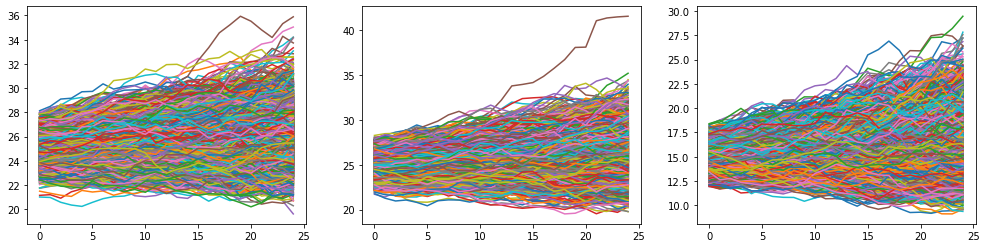

In [17]:
visualize(choice_1, data_obs)

## Transform into log returns

In [14]:
data_obs_return=np.empty([observes,para['N_OBS'],para['DIM_KNOWN']])
for i in range(observes):
    data_obs_return[i,0,:]=np.log(data_obs[i,0,:])
    for j in range(para['N_OBS']-1):
        data_obs_return[i,j+1,:]=np.log(data_obs[i,j+1])-np.log(data_obs[i,j])

In [19]:
print(np.corrcoef(data_obs[:,13,:],rowvar=False))
print(np.corrcoef(data_obs_return[:,13,:],rowvar=False))

[[ 1.          0.18203385 -0.16009125]
 [ 0.18203385  1.          0.41799243]
 [-0.16009125  0.41799243  1.        ]]
[[ 1.          0.40429902 -0.26261608]
 [ 0.40429902  1.          0.60831839]
 [-0.26261608  0.60831839  1.        ]]


## Visualization of log returns

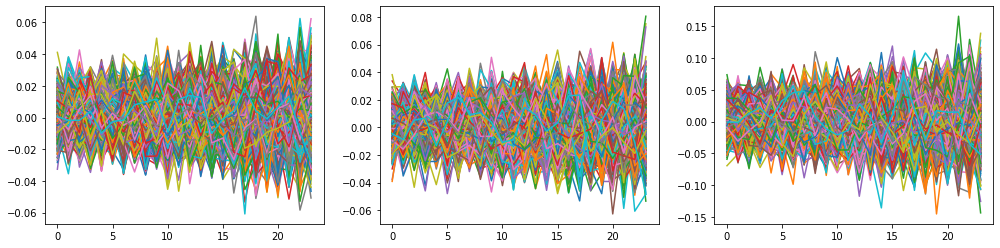

In [18]:
visualize(choice_2,data_obs_return)

## Save generated data

In [20]:
np.save('./Processed and simulated data/data_obs_'+choice_1+'.npy',data_obs)
np.save('./Processed and simulated data/data_obs_'+choice_2+'.npy',data_obs_return)